<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Model Interpretation for Pretrained ImageNet Model using RISE

This notebook demonstrates how to apply the RISE explainability method on pretrained ImageNet model using a bee image. It visualizes the relevance scores for all pixels/super-pixels by displaying them on the image.<br>

[RISE](http://bmvc2018.org/contents/papers/1064.pdf) is short for Randomized Input Sampling for Explanation of Black-box Models. It estimates importance empirically by probing the model with randomly masked versions of the input image and obtaining the corresponding outputs.<br>



#### Colab Setup

In [1]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
  # install dianna
  !python3 -m pip install dianna[notebooks]
  
  # download data used in this demo
  import os 
  base_url = 'https://raw.githubusercontent.com/dianna-ai/dianna/main/dianna/'
  paths_to_download = ['./data/bee.jpg']
  for path in paths_to_download:
      !wget {base_url + path} -P {os.path.dirname(path)}

#### 0 -  Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore') # disable warnings relateds to versions of tf
import numpy as np
from pathlib import Path
# keras model and preprocessing tools
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K
from keras import utils
# dianna library for explanation
import dianna
from dianna import visualization
# for plotting
%matplotlib inline
from matplotlib import pyplot as plt

2024-05-27 14:01:56.638218: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 14:01:56.686917: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 14:01:56.686949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 14:01:56.687945: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-27 14:01:56.697195: I tensorflow/core/platform/cpu_feature_guar

#### 1 - Loading the model and the dataset
Loads pretrained ImageNet model and the image to be explained.

Initialize the pretrained model.

In [3]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

In [4]:
model = Model()

Load and preprocess image.

In [5]:
def load_img(path):
    img = utils.load_img(path, target_size=model.input_size)
    x = utils.img_to_array(img)
    x = preprocess_input(x)
    return img, x

Call the function to load an image of a single instance in the test data from the `img` folder.

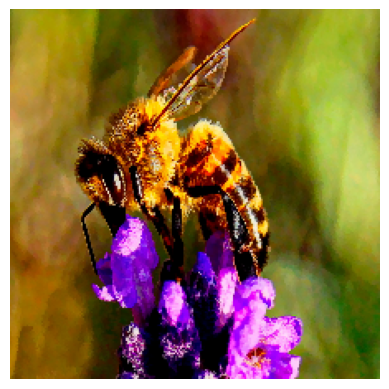

In [6]:
img, x = load_img(Path('..','..','..','dianna','data', 'bee.jpg'))
fig, ax = plt.subplots() 
ax.axis('off')
plt.imshow(img)

#### 2 - Compute and visualize the relevance scores
Compute the pixel relevance scores using RISE and visualize them on the input image. 

RISE masks random portions of the input image and passes the masked image through the model — the masked portion that decreases accuracy the most is the most “important” portion.<br>
To call the explainer and generate relevance scores map, the user need to specifiy the number of masks being randomly generated (`n_masks`), the resolution of features in masks (`feature_res`) and for each mask and each feature in the image, the probability of being kept unmasked (`p_keep`).

In [7]:
relevances = dianna.explain_image(model.run_on_batch, x, method="RISE",
                                labels=[i for i in range(1000)],
                                n_masks=1000, feature_res=6, p_keep=.1,
                                axis_labels={2: 'channels'})

Explaining:   0%|                                                                                | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 4s 722ms/step


Explaining:  10%|███████▏                                                                | 1/10 [00:04<00:41,  4.60s/it]

4/4 [==============================] - 3s 707ms/step


Explaining:  20%|██████████████▍                                                         | 2/10 [00:07<00:30,  3.82s/it]

4/4 [==============================] - 4s 1s/step


Explaining:  30%|█████████████████████▌                                                  | 3/10 [00:12<00:28,  4.06s/it]

4/4 [==============================] - 7s 2s/step


Explaining:  40%|████████████████████████████▊                                           | 4/10 [00:18<00:30,  5.10s/it]

4/4 [==============================] - 7s 2s/step


Explaining:  50%|████████████████████████████████████                                    | 5/10 [00:26<00:30,  6.01s/it]

4/4 [==============================] - 7s 2s/step


Explaining:  60%|███████████████████████████████████████████▏                            | 6/10 [00:33<00:24,  6.23s/it]

4/4 [==============================] - 7s 2s/step


Explaining:  70%|██████████████████████████████████████████████████▍                     | 7/10 [00:40<00:19,  6.44s/it]

4/4 [==============================] - 7s 2s/step


Explaining:  80%|█████████████████████████████████████████████████████████▌              | 8/10 [00:46<00:13,  6.59s/it]

4/4 [==============================] - 6s 1s/step


Explaining:  90%|████████████████████████████████████████████████████████████████▊       | 9/10 [00:53<00:06,  6.55s/it]

4/4 [==============================] - 6s 2s/step


Explaining: 100%|███████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.00s/it]


Make predictions and select the top prediction.


In [8]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

# print the name of predicted class, taking care of adding a batch axis to the model input
class_name(np.argmax(model.model.predict(x[None, ...])))

35363/35363 [==============================] - 0s 0us/step


'bee'

Visualize the relevance scores for the predicted class on top of the input image.

In [9]:
predictions = model.model.predict(x[None, ...])
prediction_ids = np.argsort(predictions)[0][-1:-6:-1]
prediction_ids

1/1 [==============================] - 0s 255ms/step


array([309, 946, 308, 319,  74])

Explanation for `bee` (0.9229555130004883)


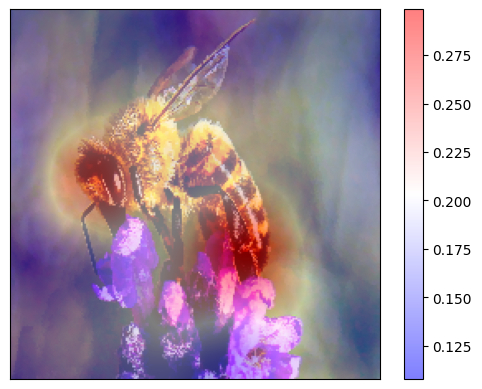

Explanation for `cardoon` (0.03968898952007294)


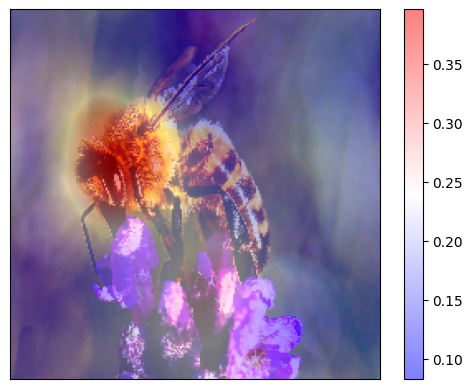

Explanation for `fly` (0.015973633155226707)


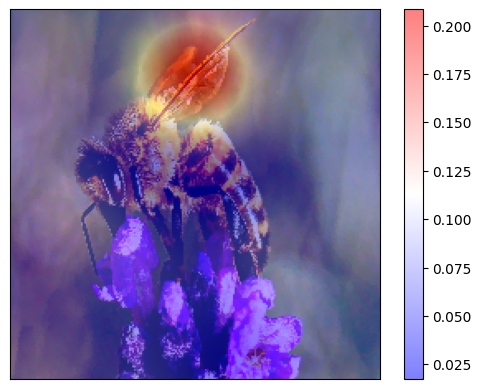

Explanation for `dragonfly` (0.0074764881283044815)


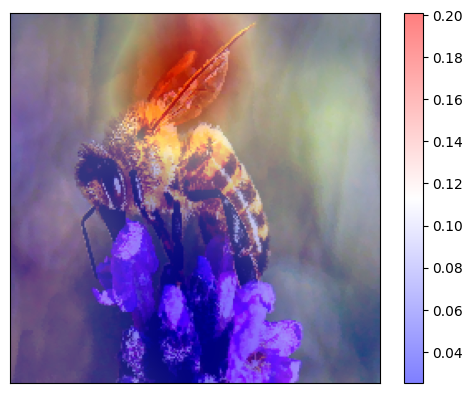

Explanation for `garden_spider` (0.005400052759796381)


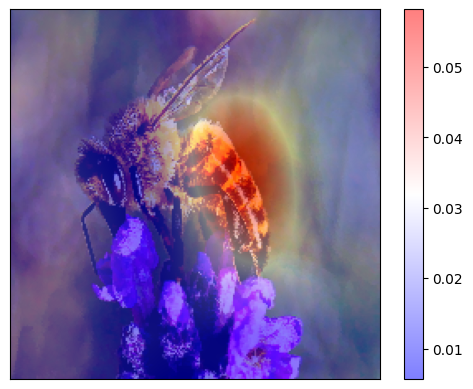

In [11]:
for class_idx in prediction_ids:
    print(f'Explanation for `{class_name(class_idx)}` ({predictions[0][class_idx]})')
    visualization.plot_image(relevances[class_idx], utils.img_to_array(img)/255., heatmap_cmap='bwr')
    plt.show()

#### 3 - Conclusions
The relevance scores are generated by passing multiple randomly masked inputs to the black-box model and averaging their scores. The idea behind this is that whenever a mask preserves important parts of the image it gets higher score. <br>

The example here shows that the RISE method evaluates the relevance of each pixel/super pixel to the classification. Pixels characterizing the bee are highlighted by the XAI approach, which gives an intuition on how the model classifies the image. The results are reasonable, based on the human visual preception of the image.